Step 1: Import Libraries and Load Data

In [1]:
# Import required libraries
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Load CSV data
csv_path = 'prices_dataset.csv'
price_data = pd.read_csv(csv_path)

# Clean and normalize the data
price_data['Product_Name'] = price_data['Product_Name'].str.strip().str.lower()
price_data['Market_Price'] = price_data['Market_Price'].astype(float)
price_data['Price_Date'] = pd.to_datetime(price_data['Price_Date'])

# Build price mapping
price_mapping = price_data.groupby('Product_Name')['Market_Price'].mean().to_dict()

print("CSV data loaded and cleaned.")


CSV data loaded and cleaned.


Step 2: Define Utility Functions

In [2]:
def plot_price_history_for_product(product_name):
    """Plots the price history for the specified product."""
    product_data = price_data[price_data['Product_Name'] == product_name]
    if not product_data.empty:
        plt.figure(figsize=(10, 6))
        plt.plot(product_data['Price_Date'], product_data['Market_Price'], marker='o', linestyle='-', color='b')
        plt.title(f'Price History of {product_name.capitalize()}')
        plt.xlabel('Date')
        plt.ylabel('Price (per kg)')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No price history found for '{product_name}'.")

def predict_price_with_history(image_path, model, class_indices, price_mapping):
    """Predicts the price for an image and shows its price history."""
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array)
        predicted_probabilities = predictions[0]
        class_index = np.argmax(predicted_probabilities)
        predicted_class_name = {v: k for k, v in class_indices.items()}[class_index]

        predicted_class_name_lower = predicted_class_name.lower()
        price = price_mapping.get(predicted_class_name_lower, "Price not available")

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(load_img(image_path))
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class_name}\nPrice: {price} per kg")

        product_data = price_data[price_data['Product_Name'] == predicted_class_name_lower]
        if not product_data.empty:
            plt.subplot(1, 2, 2)
            plt.plot(product_data['Price_Date'], product_data['Market_Price'], marker='o', linestyle='-', color='b')
            plt.title(f'Price History of {predicted_class_name}')
            plt.xlabel('Date')
            plt.ylabel('Price (per kg)')
            plt.grid(True)
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during prediction: {e}")


Step 3: Organize Dataset

In [3]:
base_dir = "./image_datasets"
split_dir = "./SplitDataset"
train_dir = os.path.join(split_dir, "train")
val_dir = os.path.join(split_dir, "val")
test_dir = os.path.join(split_dir, "test")

for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

for product in os.listdir(base_dir):
    product_path = os.path.join(base_dir, product)
    if os.path.isdir(product_path):
        images = [img for img in os.listdir(product_path) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
        train, temp = train_test_split(images, test_size=0.4, random_state=42)
        val, test = train_test_split(temp, test_size=0.5, random_state=42)

        for img in train:
            os.makedirs(os.path.join(train_dir, product), exist_ok=True)
            shutil.copy(os.path.join(product_path, img), os.path.join(train_dir, product))
        for img in val:
            os.makedirs(os.path.join(val_dir, product), exist_ok=True)
            shutil.copy(os.path.join(product_path, img), os.path.join(val_dir, product))
        for img in test:
            os.makedirs(os.path.join(test_dir, product), exist_ok=True)
            shutil.copy(os.path.join(product_path, img), os.path.join(test_dir, product))

print("Dataset split into train, validation, and test sets.")


Dataset split into train, validation, and test sets.


Step 4: Preprocess Images

In [5]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

class_indices = train_generator.class_indices
class_mapping = {v: k for k, v in class_indices.items()}
print("Class Mapping:", class_mapping)


Found 491 images belonging to 10 classes.
Found 164 images belonging to 10 classes.
Class Mapping: {0: 'Apple', 1: 'Banana', 2: 'Cabbage', 3: 'Carrot', 4: 'Eggplant', 5: 'Grapes', 6: 'Orange', 7: 'Potato', 8: 'Tomato', 9: 'Watermelon'}


Step 5: Build and Train the Model

In [ ]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

class_indices = train_generator.class_indices
class_mapping = {v: k for k, v in class_indices.items()}
print("Class Mapping:", class_mapping)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,287,562 (39.24 MB)

 Trainable params: 8,029,578 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/60
 5/16 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.2494 - loss: 6.2636

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3735 - loss: 5.3310 - val_accuracy: 0.8110 - val_loss: 0.5370
Epoch 2/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6670 - loss: 1.1014 - val_accuracy: 0.8598 - val_loss: 0.5138
Epoch 3/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7375 - loss: 0.8680 - val_accuracy: 0.8476 - val_loss: 0.6151
Epoch 4/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8167 - loss: 0.6331 - val_accuracy: 0.8841 - val_loss: 0.4702
Epoch 5/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8148 - loss: 0.6385 - val_accuracy: 0.8780 - val_loss: 0.4526
Epoch 6/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8136 - loss: 0.5711 - val_accuracy: 0.8902 - val_loss: 0.4095
Epoch 7/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8169 - loss: 0.5694 - val_accuracy: 0.9024 - val_loss: 0.3291
Epoch 8/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7988 - loss: 0.5145 - val_accuracy: 0.8659 - val_loss: 0.4297
Epo

Model saved as fruit_veg_model.h5


Step 6: Evaluate Model

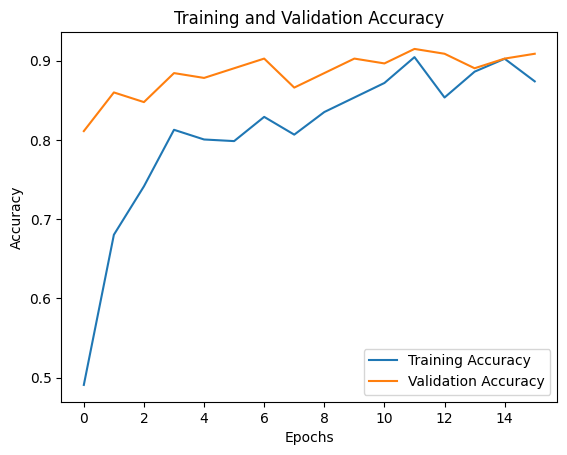

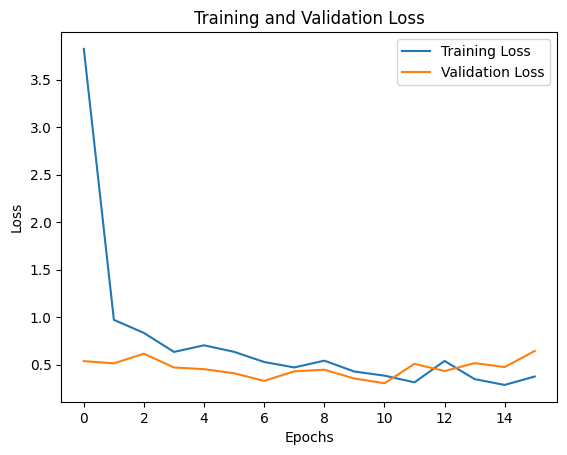

In [11]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Found 168 images belonging to 10 classes.


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step  
Model Accuracy: 92.86%


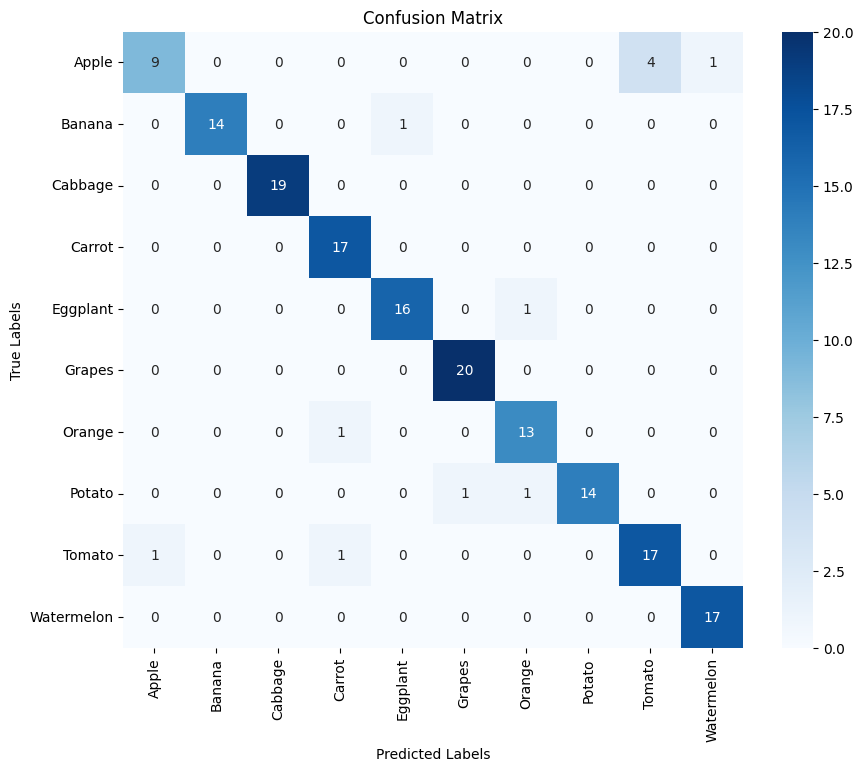

Classification Report:
              precision    recall  f1-score   support

       Apple       0.90      0.64      0.75        14
      Banana       1.00      0.93      0.97        15
     Cabbage       1.00      1.00      1.00        19
      Carrot       0.89      1.00      0.94        17
    Eggplant       0.94      0.94      0.94        17
      Grapes       0.95      1.00      0.98        20
      Orange       0.87      0.93      0.90        14
      Potato       1.00      0.88      0.93        16
      Tomato       0.81      0.89      0.85        19
  Watermelon       0.94      1.00      0.97        17

    accuracy                           0.93       168
   macro avg       0.93      0.92      0.92       168
weighted avg       0.93      0.93      0.93       168



In [12]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

true_labels = test_generator.classes
predicted_probabilities = model.predict(test_generator)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

accuracy = np.mean(predicted_labels == true_labels)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=list(class_mapping.values())))


Step 7: Make Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


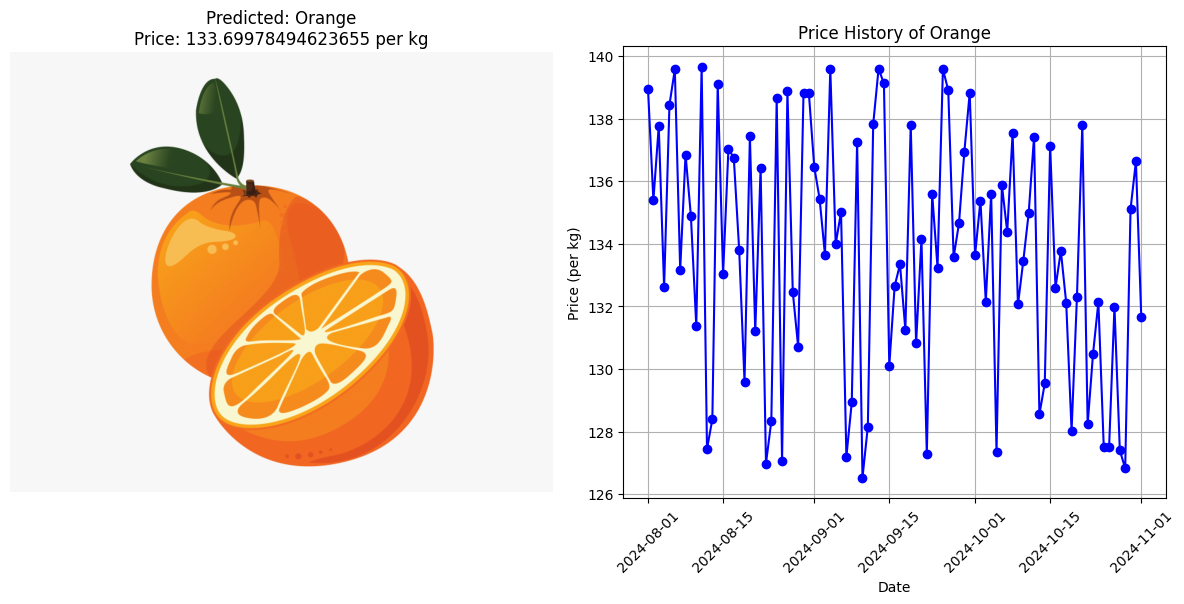

In [14]:
example_image_path = './SplitDataset/test/Orange/Image_84.png'  # Replace with a real path
predict_price_with_history(example_image_path, model, class_indices, price_mapping)